In [37]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
import simplejson as json
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import metrics as skmetrics
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.utils.vis_utils import plot_model
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate, SimpleRNN
from keras.utils.vis_utils import plot_model
from google.cloud import storage
from google.cloud.storage import Blob

client = storage.Client(project="ds5500")

bucket = client.get_bucket("kkbox-data")

#INPUT_PATH = "D:\\Northeastern\\100 pct undersample split\\"
INPUT_PATH = "gs://kkbox-data/data_100_pct_undersample/"

# Load Member/Transaction Data

In [38]:
# Load TRAINING data
temp_path = "/tmp/train_transactions_monthly_padded.npy"
blob = Blob("data_100_pct_undersample/train_transactions_monthly_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_transactions = np.load(temp_path)
X_members = pd.read_csv(INPUT_PATH + "X_train_transformed.csv").sort_values("msno").drop(["msno"],axis=1).values
y = pd.read_csv(INPUT_PATH + "y_train.csv", header=None).sort_values(0).drop([0],axis=1).values

In [44]:
# Load VALIDATION data
temp_path = "/tmp/val_transactions_monthly_padded.npy"
blob = Blob("data_100_pct_undersample/val_transactions_monthly_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_transactions = np.load(temp_path)
X_val_members = pd.read_csv(INPUT_PATH + "X_val_transformed.csv").sort_values("msno").drop(["msno"],axis=1).values
y_val = pd.read_csv(INPUT_PATH + "y_val.csv", header=None).sort_values(0).drop([0],axis=1).values

# Weekly User Logs, Monthly Transactions, Member Data

In [40]:
# Load training weekly user logs from GCS
temp_path = "/tmp/train_user_logs_weekly_padded.npy"
blob = Blob("data_100_pct_undersample/train_user_logs_weekly_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_user_logs = np.load(temp_path)

In [45]:
# Load testing weekly user logs from GCS
temp_path = "/tmp/val_user_logs_weekly_padded.npy"
blob = Blob("data_100_pct_undersample/val_user_logs_weekly_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_val_user_logs = np.load(temp_path)

In [53]:
batch_size = 32
epochs = 15
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
#a = LSTM(lstm_units)(a)
a = Dense(16, activation='relu')(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c = Dense(16, activation='relu')(c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([a_mod.output, b_mod.output, c_mod.output])
out = Dense(32, activation='relu')(combined)
out = Dense(16, activation='relu')(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[a_mod.input, b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

#model.summary()
model.fit([X_user_logs, X_members, X_transactions], y, validation_data=([X_val_user_logs, X_val_members, X_val_transactions],y_val), batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Train on 24798 samples, validate on 6200 samples
Epoch 1/15
24798/24798 [==============================] - 17s 704us/step - loss: 0.4473 - auc_13: 0.8278 - val_loss: 0.4259 - val_auc_13: 0.8679
Epoch 2/15
24798/24798 [==============================] - 16s 647us/step - loss: 0.4128 - auc_13: 0.8738 - val_loss: 0.4100 - val_auc_13: 0.8773
Epoch 3/15
24798/24798 [==============================] - 16s 643us/step - loss: 0.4052 - auc_13: 0.8803 - val_loss: 0.4070 - val_auc_13: 0.8824
Epoch 4/15
24798/24798 [==============================] - 16s 649us/step - loss: 0.4016 - auc_13: 0.8838 - val_loss: 0.4034 - val_auc_13: 0.8852
Epoch 5/15
24798/24798 [==============================] - 16s 654us/step - loss: 0.3973 - auc_13: 0.8864 - val_loss: 0.4015 - val_auc_13: 0.8875
Epoch 6/15
24798/24798 [==============================] - 16s 643us/step - loss: 0.3953 - auc_13: 0.8883 - val_loss: 0.3996 - val_auc_13: 0.8891
Epoch 7/15
24798/24798 [==============================] - 16s 645us/step - loss: 

# Daily User Logs, Monthly Transactions, Member Data

In [ ]:
# Load weekly user logs from GCS
temp_path = "/tmp/train_user_logs_padded.npy"
blob = Blob("data_100_pct_undersample/train_user_logs_padded.npy", bucket)

with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)
X_user_logs = np.load(temp_path)

In [32]:
batch_size = 64
epochs = 20
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
#a = LSTM(lstm_units)(a)
a = Dense(16, activation='relu')(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([a_mod.output, b_mod.output, c_mod.output])
out = Dense(16, activation='relu')(combined)
#TODO add dropout layer
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[a_mod.input, b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

#model.summary()
model.fit([X_user_logs, X_members, X_transactions], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Epoch 1/20
24798/24798 [==============================] - 82s 3ms/step - loss: 0.4716 - auc_7: 0.8200
Epoch 2/20
24798/24798 [==============================] - 72s 3ms/step - loss: 0.4145 - auc_7: 0.8664
Epoch 3/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.4077 - auc_7: 0.8756
Epoch 4/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.4037 - auc_7: 0.8802
Epoch 5/20
24798/24798 [==============================] - 81s 3ms/step - loss: 0.4006 - auc_7: 0.8833
Epoch 6/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.3983 - auc_7: 0.8856
Epoch 7/20
24798/24798 [==============================] - 80s 3ms/step - loss: 0.3966 - auc_7: 0.8873
Epoch 8/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.3961 - auc_7: 0.8887
Epoch 9/20
24798/24798 [==============================] - 80s 3ms/step - loss: 0.3954 - auc_7: 0.8897
Epoch 10/20
24798/24798 [==============================] - 78s 3ms/step - loss: 0.

# Transactions and Member Data

In [33]:
batch_size = 64
epochs = 20
lstm_units = 16
rnn_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]
num_transaction_cols = X_transactions.shape[2]
num_transaction_months = X_transactions.shape[1]

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

data_in_c = Input(shape = (num_transaction_months,num_transaction_cols,))
c = SimpleRNN(rnn_units)(data_in_c)
c_mod = Model(data_in_c, outputs=c)

combined = concatenate([b_mod.output, c_mod.output])
out = Dense(16, activation='relu')(combined)
#TODO add dropout layer
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[b_mod.input, c_mod.input], outputs=out)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

#model.summary()
model.fit([X_members, X_transactions], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Epoch 1/20
24798/24798 [==============================] - 3s 104us/step - loss: 0.4765 - auc_8: 0.8282
Epoch 2/20
24798/24798 [==============================] - 2s 78us/step - loss: 0.4266 - auc_8: 0.8589
Epoch 3/20
24798/24798 [==============================] - 2s 81us/step - loss: 0.4209 - auc_8: 0.8659
Epoch 4/20
24798/24798 [==============================] - 2s 83us/step - loss: 0.4173 - auc_8: 0.8700
Epoch 5/20
24798/24798 [==============================] - 2s 81us/step - loss: 0.4152 - auc_8: 0.8729
Epoch 6/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4143 - auc_8: 0.8750
Epoch 7/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4128 - auc_8: 0.8766
Epoch 8/20
24798/24798 [==============================] - 2s 80us/step - loss: 0.4112 - auc_8: 0.8778
Epoch 9/20
24798/24798 [==============================] - 2s 79us/step - loss: 0.4094 - auc_8: 0.8788
Epoch 10/20
24798/24798 [==============================] - 2s 82us/step - loss: 0

# User Logs and Member Data (LSTM)

# Member data only

# Visualize Model

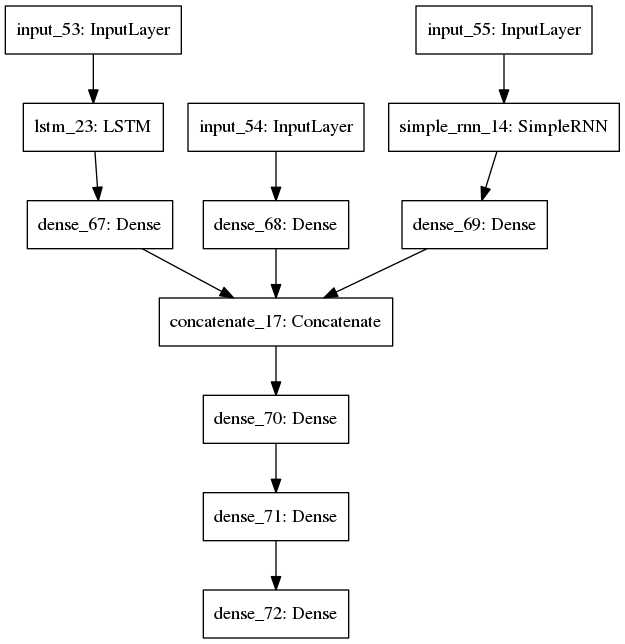

In [59]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils import plot_model
plot_model(model, to_file='model.png')